<a href="https://colab.research.google.com/github/pabloderen/BIMnferer/blob/master/Pipe_Analysis_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [105]:
import pandas as pd
import json
import urllib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
import numpy as np


# Download the Data

We download from de API in Flasgger (http://3.14.88.102:5000/apidocs/) the Pipe list item and it´s parameters


In [63]:
jsonfile = urllib.request.urlopen("http://3.14.88.102:5000/api/1/elements/pipes/?limit=6500").read().decode()
j=json.loads(jsonfile)

Then we make a Data Frame with the json file

# Create the DataFrame

In [64]:
df= pd.json_normalize(j)
df.head(3)

,projectId,Category,modelId,_id.$oid,properties_Dimensions_Length,properties_Dimensions_Size,properties_Mechanical_Material,properties_Mechanical_System Classification
0,b.c94f85e5-88fb-402c-bc60-72622f5f85b6,Pipes,d4ea3308-4b3f-d382-cacb-9791f772042b,5eee8651cb573f2fc2216a82,NaN,NaN,NaN,NaN
1,b.c94f85e5-88fb-402c-bc60-72622f5f85b6,Pipes,d4ea3308-4b3f-d382-cacb-9791f772042b,5eee8651cb573f2fc2216a83,NaN,NaN,NaN,NaN
2,b.c94f85e5-88fb-402c-bc60-72622f5f85b6,Pipes,d4ea3308-4b3f-d382-cacb-9791f772042b,5eee8651cb573f2fc2216a84,0.398 ft,"2 1/2""",Copper,Sanitary


# Material Edition

we can see how many different materials we have, so then we will 
group by PVC, Copper and Steel

In [65]:
df["properties_Mechanical_Material"].unique()

array([nan, 'Copper', 'Steel, Carbon', '<By Category>',
       'Polyvinyl Chloride - Rigid', 'CP_PI - Copper - ASTM B88 H.D.',
       'CP_PI - Steel - ASTM A53-B', 'CP_PI - PVC', 'Cast Iron',
       'Black Steel', 'Carbon Steel', 'Ductile Iron',
       'Polyvinyl Chloride, Rigid', 'Carbon Steel - ASTM A53 B'],
      dtype=object)

To make such a grouping, we define a function that search in the "properties_Mechanical_Material" and change each row that has another different name for the same material

In [66]:
def search(data):
   
    if "A53" in data.upper():
        return "Carbon Steel - ASTM A53 B"
    if "CATEGORY" in data.upper():
        return "NaN"
    if "POLYVINYL" in data.upper():
        return "PVC"
    if "PVC" in data.upper():
        return "PVC"
    if "NAN" in data.upper():
        return "NaN"
    else:
        return data

For practical purpuses, we will make a copy of the DataFrame, 
then apply the function in each row of the "properties_Mechanical_Material" column.

In [67]:
df2=df
df2["properties_Mechanical_Material"]=df2["properties_Mechanical_Material"].apply(lambda x: search(str(x)))


here is the amount of each material kind

In [68]:

df2["properties_Mechanical_Material"].value_counts()


PVC                               1745
Carbon Steel                      1737
Carbon Steel - ASTM A53 B         1322
Copper                            1102
CP_PI - Copper - ASTM B88 H.D.     424
Steel, Carbon                      121
NaN                                 41
Black Steel                          4
Cast Iron                            2
Ductile Iron                         2
Name: properties_Mechanical_Material, dtype: int64

Here we can see a graphic of the different amount of each materials:

# Graphics

[Text(0, 0.5, 'Material')]

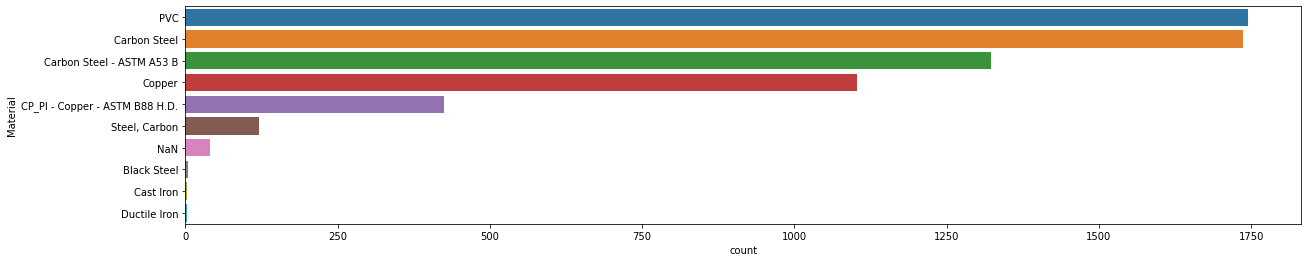

In [69]:

plt.figure(figsize=(20,4))
ax=sns.countplot(y="properties_Mechanical_Material",data=df2,order=df2["properties_Mechanical_Material"].value_counts().index)
ax.set( ylabel="Material")

In [9]:
df2["properties_Mechanical_System Classification"].value_counts()

Sanitary               1499
Hydronic Supply        1496
Hydronic Return        1209
Domestic Cold Water     716
Vent                    417
Domestic Hot Water      321
Other                   187
Fire Protection Dry     116
Fire Protection Wet       2
Name: properties_Mechanical_System Classification, dtype: int64

Here we have an graphic of the system

[Text(0, 0.5, 'System Classification')]

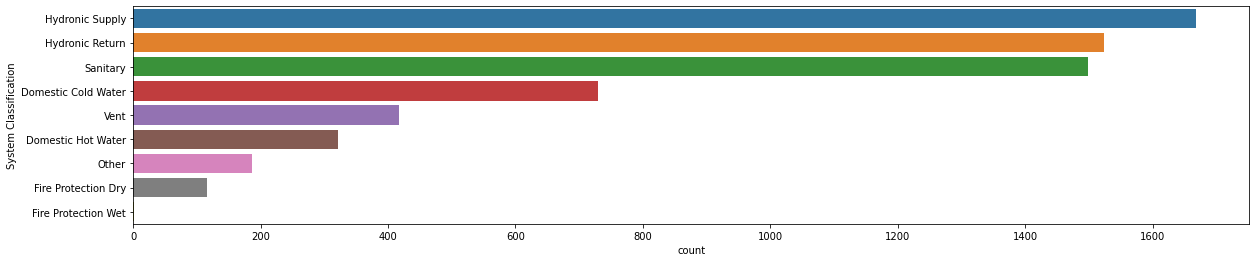

In [70]:
plt.figure(figsize=(20,4))
ax=sns.countplot(y="properties_Mechanical_System Classification",data=df2,order=df2["properties_Mechanical_System Classification"].value_counts().index)
ax.set( ylabel="System Classification")

# Length Edition

We drop the rows with properties_Dimensions_Length NaN values.

In [71]:
df3=df2.dropna(axis=0,subset=["properties_Dimensions_Length"])


Her we start to convert the properties_Dimensions_Length from string to float 
(we use x.replace(" ft","") and x.replace("  ft",""), notice the spaces in each case)



In [72]:
df3["properties_Dimensions_Length"]= df3["properties_Dimensions_Length"].apply(lambda x: x.replace(" ft",""))
df3["properties_Dimensions_Length"]= df3["properties_Dimensions_Length"].apply(lambda x: x.replace("  ft",""))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [73]:
df3["properties_Dimensions_Length"]= df3["properties_Dimensions_Length"].apply(lambda x: float(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Size Edition

we are analazing pipes, so we know that the dimensions Sizes are the diameter sizes. Then we can see that because a Size has the diameter simbol, creates another dimension. So we will take of the diameter simbol of all the column.

In [74]:
df3["properties_Dimensions_Size"].value_counts().head(5)

2"     643
4"ø    612
6"ø    549
4"     522
3"     436
Name: properties_Dimensions_Size, dtype: int64

In [75]:
df3["properties_Dimensions_Size"]= df3["properties_Dimensions_Size"].apply(lambda x: x.replace("ø",""))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Here we eliminate any leading and trailing whitespaces

In [76]:
df3["properties_Dimensions_Size"]= df3["properties_Dimensions_Size"].apply(lambda x: x.strip())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [77]:
df3["properties_Dimensions_Size"].value_counts()

4"        1152
2"         843
3/4"       745
6"         719
3"         704
1"         598
2 1/2"     340
1 1/2"     310
1 1/4"     309
1/2"       241
16"        146
14"         96
8"          88
12"         64
10"         60
5"          22
30"         22
1 3/8"       2
36"          2
Name: properties_Dimensions_Size, dtype: int64

[Text(0.5, 0, 'Dimensions Size')]

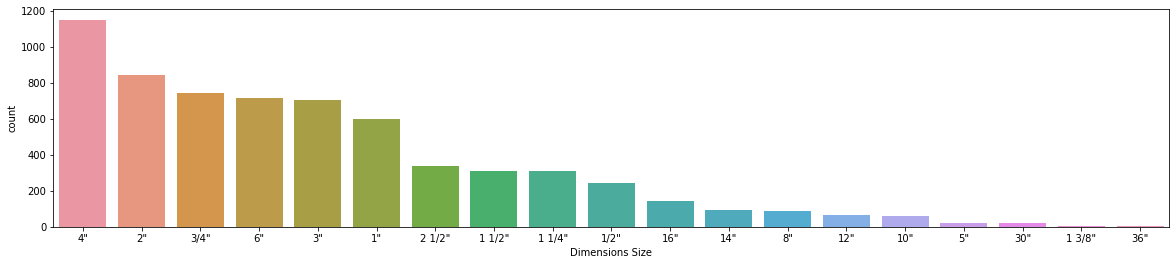

In [78]:
plt.figure(figsize=(20,4))
ax=sns.countplot(x="properties_Dimensions_Size",data=df3,order=df3["properties_Dimensions_Size"].value_counts().index)
ax.set( xlabel= "Dimensions Size")

# Enlist Materials

The ""properties_Mechanical_Material" are 10 different types. Our target of inference will be the differents kinds of materials

In [79]:
 lista = df3["properties_Mechanical_Material"].unique()
lista

array(['Copper', 'Steel, Carbon', 'NaN', 'PVC',
       'CP_PI - Copper - ASTM B88 H.D.', 'Carbon Steel - ASTM A53 B',
       'Cast Iron', 'Black Steel', 'Carbon Steel', 'Ductile Iron'],
      dtype=object)

Set a number designator to all properties_Mechanical_System Classification

In [80]:
dicc={}
i=0
for i in range(0,10):
  dicc[lista[i]]=i

we create a column with this designation

In [81]:
df3["Material_Number"]=df3["properties_Mechanical_Material"].apply(lambda x: dicc[x])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Dummies Data

Then we get the dummies properties_Dimensions_Size and properties Mechanical System Classification

In [82]:
df3["properties_Dimensions_Size"].nunique()

19

In [83]:
classification= pd.get_dummies(df3["properties_Mechanical_System Classification"])


In [84]:
Dimensions_Size= pd.get_dummies(df3["properties_Dimensions_Size"])


In [25]:
df4 = pd.concat([df3,classification,Dimensions_Size],axis=1)

We eliminate some columns that we will not use 

In [425]:
droplist=["Category","properties_Mechanical_System Classification","properties_Mechanical_Material"
,"properties_Dimensions_Size", "projectId", "modelId","_id.$oid"]
df5=df4.drop(droplist, axis=1)

In [426]:
df5.head(3)

,properties_Dimensions_Length,Material_Number,Domestic Cold Water,Domestic Hot Water,Fire Protection Dry,Fire Protection Wet,Hydronic Return,Hydronic Supply,Other,Sanitary,Vent,"1 1/2""","1 1/4""","1 3/8""","1""","1/2""","10""","12""","14""","16""","2 1/2""","2""","3""","3/4""","4""","5""","6""","8"""
2,0.398,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,2.536,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
5,0.031,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


# Train Test Split

Here we define the size of our test size. We will use a 30% of the download data

In [428]:
X = df5.drop('Material_Number',axis=1)
y = df5['Material_Number']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

# Model Fit

 Here we train our Random Forest

In [429]:
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

# Predictions

In [430]:

predictions = rfc.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))


              precision    recall  f1-score   support

           0       0.92      0.84      0.88       116
           1       1.00      1.00      1.00         6
           3       0.99      0.98      0.99       173
           4       0.77      0.94      0.85        47
           5       1.00      0.99      0.99       138
           8       0.95      0.97      0.96       117

    accuracy                           0.95       597
   macro avg       0.94      0.95      0.94       597
weighted avg       0.95      0.95      0.95       597



# Dispersion Analysis

Here we compare the Mean Absolute error of the inferences made with and without consider the lenghts of the pipes.

-With Pipe Lengths MAE= 0.23

-Without Pipe Lengths MAE= 0.69

So we note that the lengths give us more dispersion, and we will take off from the inference

In [431]:
score = mean_absolute_error(y_test,predictions)
print('MAE:', score)

MAE: 0.23618090452261306


# Sección nueva

In [143]:
dicc

{'Black Steel': 7,
 'CP_PI - Copper - ASTM B88 H.D.': 4,
 'Carbon Steel': 8,
 'Carbon Steel - ASTM A53 B': 5,
 'Cast Iron': 6,
 'Copper': 0,
 'Ductile Iron': 9,
 'NaN': 2,
 'PVC': 3,
 'Steel, Carbon': 1}

# Download the Data (second part)

In [146]:

jsonfile2= urllib.request.urlopen("http://3.14.88.102:5000/api/1/elements/pipes/?limit=6500").read().decode()
j2=json.loads(jsonfile2)

In [147]:
dataf= pd.json_normalize(j2)
dataf.head(3)

,projectId,Category,modelId,_id.$oid,properties_Dimensions_Length,properties_Dimensions_Size,properties_Mechanical_Material,properties_Mechanical_System Classification
0,b.c94f85e5-88fb-402c-bc60-72622f5f85b6,Pipes,d4ea3308-4b3f-d382-cacb-9791f772042b,5eee8651cb573f2fc2216a82,NaN,NaN,NaN,NaN
1,b.c94f85e5-88fb-402c-bc60-72622f5f85b6,Pipes,d4ea3308-4b3f-d382-cacb-9791f772042b,5eee8651cb573f2fc2216a83,NaN,NaN,NaN,NaN
2,b.c94f85e5-88fb-402c-bc60-72622f5f85b6,Pipes,d4ea3308-4b3f-d382-cacb-9791f772042b,5eee8651cb573f2fc2216a84,0.398 ft,"2 1/2""",Copper,Sanitary


# Data to Infer

For a given Item, we infer what material it could be. In this case we toke the 100th elemnt

In [482]:
eli=dataf.iloc[100].to_frame().T
#First individualizate the elemnt
eli


,projectId,Category,modelId,_id.$oid,properties_Dimensions_Length,properties_Dimensions_Size,properties_Mechanical_Material,properties_Mechanical_System Classification
100,b.c94f85e5-88fb-402c-bc60-72622f5f85b6,Pipes,d4ea3308-4b3f-d382-cacb-9791f772042b,5eee866fcb573f2fc2216e7e,4.083 ft,"4""",Polyvinyl Chloride - Rigid,Sanitary


here we make a dictionary with the size, classification and Length elements

In [488]:

def search_title(var):
  i=0
  values={}

  Ele=var.iloc[0].index.nunique()
  for i in range(0,Ele):
    value=var.iloc[0].index[i].upper()
    if "SIZE" in value:
        values["Size"]=var.iloc[0][i]

    if "CLASSIFICATION" in value:
        values["Classification"]=var.iloc[0][i]

    if "LENGTH" in value:
        values["Length"]=var.iloc[0][i]
  return values

item=search_title(eli)
item


{'Classification': 'Sanitary', 'Length': '4.083 ft', 'Size': '4"'}

Edit the Size format

In [489]:
item["Size"]=item["Size"].replace("ø","")
item["Size"]=item["Size"].strip()
item["Size"]

'4"'

Edit the Lenght format

In [490]:
item["Length"]=item["Length"].replace(" ft","")
item["Length"]=item["Length"].replace("  ft","")
item["Length"]
item["Length"]

'4.083'

In [473]:
pro=df5.columns.to_frame(index=True).T
pro.drop(labels=0,axis=0,inplace=True)

In [496]:
#this list is just for make the new_row dictionary 
items=[item["Classification"],item["Size"]]

new_row={}

for i in pro.columns:
  if i == "properties_Dimensions_Length":
    new_row[i]=float(item["Length"])
  elif i in items:
    new_row[i]=1
  else:
      new_row[i]=0


In [495]:
new_row

{'1 1/2"': 0,
 '1 1/4"': 0,
 '1 3/8"': 0,
 '1"': 0,
 '1/2"': 0,
 '10"': 0,
 '12"': 0,
 '14"': 0,
 '16"': 0,
 '2 1/2"': 0,
 '2"': 0,
 '3"': 0,
 '3/4"': 0,
 '4"': 1,
 '5"': 0,
 '6"': 0,
 '8"': 0,
 'Domestic Cold Water': 0,
 'Domestic Hot Water': 0,
 'Fire Protection Dry': 0,
 'Fire Protection Wet': 0,
 'Hydronic Return': 0,
 'Hydronic Supply': 0,
 'Material_Number': 0,
 'Other': 0,
 'Sanitary': 1,
 'Vent': 0,
 'properties_Dimensions_Length': 4.083}

This is the one row DataFrame that we will use to test the model to predict

In [476]:
k=pro.append(new_row, ignore_index=True)

In [477]:
X_infer = k.drop('Material_Number',axis=1)
y_infer = pro['Material_Number']

In [507]:
predictions = rfc.predict(X_infer)
int(predictions)

3

Recalling the dictionary we made, we change key for value and vice versa

In [497]:
dicc

{'Black Steel': 7,
 'CP_PI - Copper - ASTM B88 H.D.': 4,
 'Carbon Steel': 8,
 'Carbon Steel - ASTM A53 B': 5,
 'Cast Iron': 6,
 'Copper': 0,
 'Ductile Iron': 9,
 'NaN': 2,
 'PVC': 3,
 'Steel, Carbon': 1}

In [504]:
dicc2={}

for i in dicc.keys():
  dicc2[dicc[i]]=i
dicc2


{0: 'Copper',
 1: 'Steel, Carbon',
 2: 'NaN',
 3: 'PVC',
 4: 'CP_PI - Copper - ASTM B88 H.D.',
 5: 'Carbon Steel - ASTM A53 B',
 6: 'Cast Iron',
 7: 'Black Steel',
 8: 'Carbon Steel',
 9: 'Ductile Iron'}

In [509]:
dicc2[int(predictions)]

'PVC'